In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scdna_replication_tools.plot_utils import get_clone_cmap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
from scipy.stats import hypergeom
from matplotlib import colors as mcolors
from scgenome import cncluster
from scdna_replication_tools.plot_utils import get_rt_cmap, get_clone_cmap, plot_colorbar, make_color_mat_float, plot_clustered_cell_cn_matrix

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

### Load and preprocess data for cell cycle clone counts for SA1035U 

In [3]:
def timepoint_to_int(df):
    """Converts the timepoint column to an integer"""
    # get the timepoint column
    timepoints = df['timepoint'].values
    # convert the timepoints to integers
    timepoints = [int(x[1:]) for x in timepoints]
    # add the timepoints to the dataframe
    df['timepoint_int'] = timepoints
    # return the dataframe
    return df


def sort_timepoints(df):
    """Sort the dataframe according to clone_id and timepoint_int"""
    # if timepoint_int is not in the dataframe, create such a column
    df = timepoint_to_int(df)
    # sort the dataframe
    df = df.sort_values(by=['clone_id', 'timepoint_int'])
    # return the dataframe
    return df


def fill_in_missing_clones(df, clone_list=None):
    """ If there are clones present at some timepoints but not others, fill in the missing clones with 0s """
    # find the clone list if not specified
    if clone_list is None:
        clone_list = df.clone_id.unique()
    # loop through the clones and timepoints
    for clone in clone_list:
        for timepoint in df.timepoint.unique():
            # if the clone is not present at the timepoint, add a row with 0s
            if clone not in df[df.timepoint == timepoint].clone_id.values:
                new_line = pd.DataFrame({
                    'clone_id': [clone], 'timepoint': [timepoint], 'num_cells_s': [0], 'num_cells_g': [0],
                    'clone_frac_s': [0], 'clone_frac_g': [0], 'positive_p': [0], 'negative_p': [0],
                    'positive_p_adj': [0], 'negative_p_adj': [0], 'timepoint_int': [int(timepoint[1:])]
                })
                # concatenate the new line to the dataframe
                df = pd.concat([df, new_line], ignore_index=True)
    return df


def compute_clone_fracs_vs_time(df):
    """
    Computes the fraction of cells in each clone for each timepoint.
    """
    clone_frac_g_vs_time = np.zeros((len(df.clone_id.unique()), len(df.timepoint_int.unique())))
    clone_frac_s_vs_time = np.zeros((len(df.clone_id.unique()), len(df.timepoint_int.unique())))
    clone_legend = []
    timepoints = df.timepoint_int.unique()
    i = 0
    for clone_id, chunk in df.groupby('clone_id'):
        chunk.sort_values(by='timepoint_int', inplace=True)
        clone_frac_g_vs_time[i] = chunk['clone_frac_g'].values
        clone_frac_s_vs_time[i] = chunk['clone_frac_s'].values
        clone_legend.append(clone_id)
        i += 1
    return timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend

In [4]:
# load the cell cycle clone counts for SA1035U
df_SA1035U = pd.read_csv('scdna_replication_paper/analysis/fitness/SA1035U/cell_cycle_clone_counts.tsv', sep='\t')

# sort timepoints based on the timepoint_int column
df_SA1035U = sort_timepoints(df_SA1035U)

# find the earliest timepoint in the untreated sample
earliest_timepoint = sorted(df_SA1035U.timepoint_int.unique())[0]

# find the set of clone_ids that appear in the union of the treated and untreated samples
clone_list = list(set(df_SA1035U.clone_id.unique()))
# fill in missing clones with 0s
df_SA1035U = fill_in_missing_clones(df_SA1035U, clone_list)

# sort timepoints again now that we've added the earliest untreated timepoint and filled in missing clones
df_SA1035U = sort_timepoints(df_SA1035U)

### Plot the fraction of cells in each cell cycle phase for each clone across all timepoints

In [5]:
def plot_clone_stackplots(df_U, dataset, ax_g, ax_s):
    """
    Plots the evolution of clones over time for each cell cycle phase. 
    """
    # split the dataframe based on cell cycle and find the fraction of cells in each clone at each timepoint for each cell cycle phase
    timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend = compute_clone_fracs_vs_time(df_U)
    # plot as a stackplot
    baseline = 'zero'
    ax_g.stackplot(timepoints, clone_frac_g_vs_time, labels=clone_legend, baseline=baseline)
    ax_s.stackplot(timepoints, clone_frac_s_vs_time, labels=clone_legend, baseline=baseline)
    ax_g.set_ylabel('clone fraction')
    ax_g.set_xlabel('timepoint')
    ax_s.set_xlabel('timepoint')
    ax_g.set_title('{}: G1/2-phase'.format(dataset))
    ax_s.set_title('{}: S-phase'.format(dataset))
    ax_s.legend(title='clone')

In [6]:
def plot_clone_muller(df, dataset, ax_g, ax_s, interpolate=True, std=5, clone_cmap=get_clone_cmap()):
    """
    Plots the evolution of clones over time for each cell cycle phase. 
    """
    # split the dataframe based on cell cycle and find the fraction of cells in each clone at each timepoint for each cell cycle phase
    timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend = compute_clone_fracs_vs_time(df)
    og_timepoints = timepoints

    if interpolate:
        clone_frac_g_vs_time = pd.DataFrame(clone_frac_g_vs_time, index=clone_legend, columns=timepoints)
        clone_frac_s_vs_time = pd.DataFrame(clone_frac_s_vs_time, index=clone_legend, columns=timepoints)
            
        # add columns with NaNs for the 0.5 intervals betweeen timepoints
        for i in range(min(timepoints), max(timepoints)):
            for frac in np.linspace(0.1, 0.9, 9):
                clone_frac_g_vs_time[i + frac] = np.nan
                clone_frac_s_vs_time[i + frac] = np.nan

        # sort the columns based on timepoint
        clone_frac_g_vs_time = clone_frac_g_vs_time.reindex(sorted(clone_frac_g_vs_time.columns), axis=1)
        clone_frac_s_vs_time = clone_frac_s_vs_time.reindex(sorted(clone_frac_s_vs_time.columns), axis=1)
        timepoints = clone_frac_g_vs_time.columns

        # interpolate the NaNs
        # clone_frac_g_vs_time = clone_frac_g_vs_time.interpolate(method='spline', order=3, axis=1)
        # clone_frac_s_vs_time = clone_frac_s_vs_time.interpolate(method='spline', order=3, axis=1)
        clone_frac_g_vs_time = clone_frac_g_vs_time.T.rolling(len(timepoints), 1, True, 'gaussian').mean(std=std).T
        clone_frac_s_vs_time = clone_frac_s_vs_time.T.rolling(len(timepoints), 1, True, 'gaussian').mean(std=std).T
    
    # set x-axis ticks to all the timepoints we have measurements for
    ax_g.set_xticks(og_timepoints)
    ax_s.set_xticks(og_timepoints)

    clone_colors = [clone_cmap[x] for x in clone_legend]

    # plot as a stackplot
    baseline = 'zero'
    ax_g.stackplot(timepoints, clone_frac_g_vs_time, labels=clone_legend, baseline=baseline, colors=clone_colors)
    ax_s.stackplot(timepoints, clone_frac_s_vs_time, labels=clone_legend, baseline=baseline, colors=clone_colors)
    ax_g.set_ylabel('clone fraction')
    ax_g.set_xlabel('timepoint')
    ax_s.set_xlabel('timepoint')
    ax_g.set_title('{}: G1/2-phase'.format(dataset))
    ax_s.set_title('{}: S-phase'.format(dataset))
    ax_s.legend(title='clone')
    # set the x-axis limits to be the very first and last timepoints
    ax_s.set_xlim(min(timepoints), max(timepoints))
    ax_g.set_xlim(min(timepoints), max(timepoints))

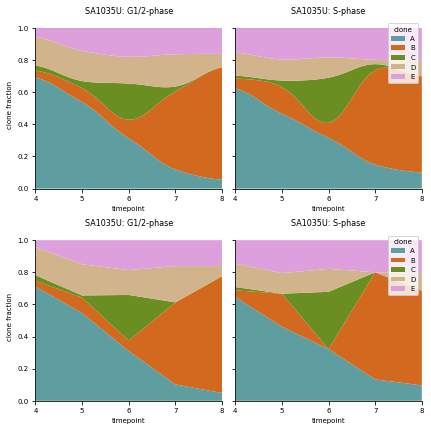

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True, sharey=True)
ax = ax.flatten()

# plot clone fractions for each phase & timepoint in the form of a stackplot
plot_clone_muller(df_SA1035U, 'SA1035U', ax[0], ax[1], std=5)
plot_clone_muller(df_SA1035U, 'SA1035U', ax[2], ax[3], interpolate=False)
sns.despine(ax=ax[0], offset=0, trim=despine_trim)
sns.despine(ax=ax[1], offset=0, trim=despine_trim)
sns.despine(ax=ax[2], offset=0, trim=despine_trim)
sns.despine(ax=ax[3], offset=0, trim=despine_trim)

plt.show()

### Check to see that the muller plots look reasonable across all datasets

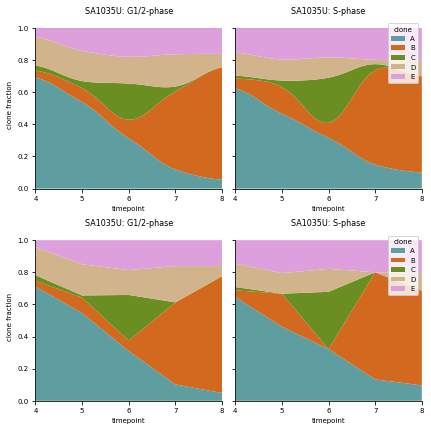

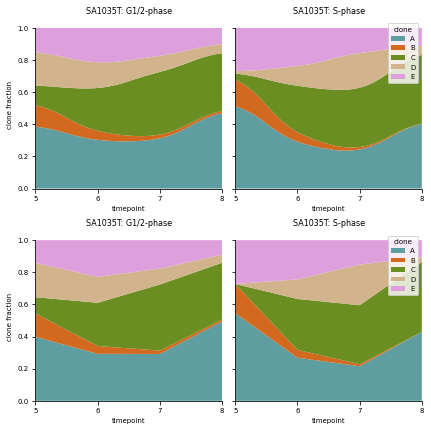

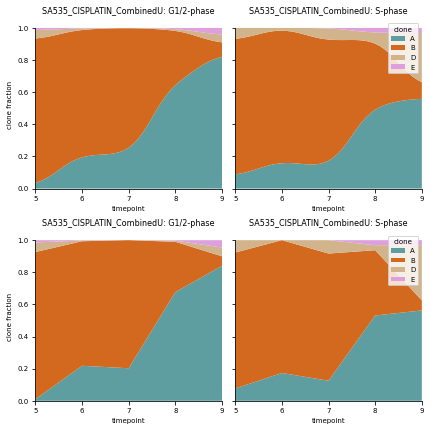

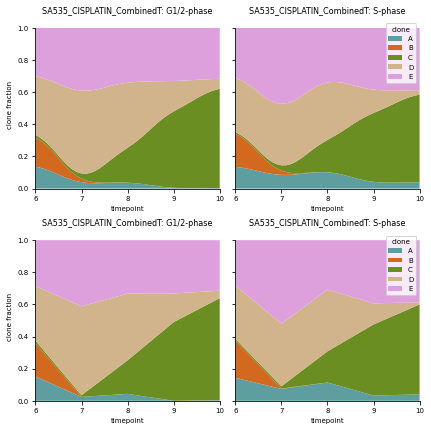

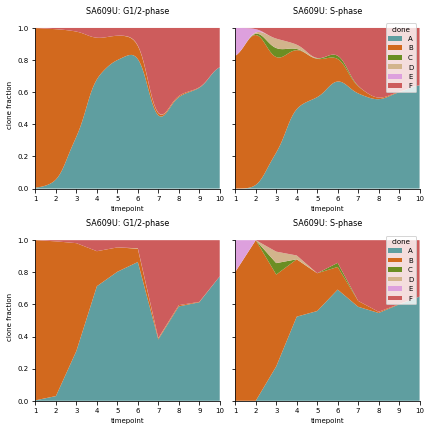

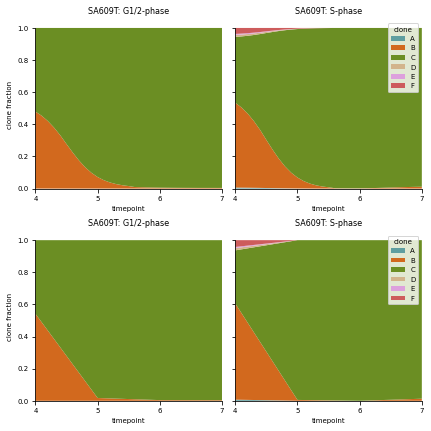

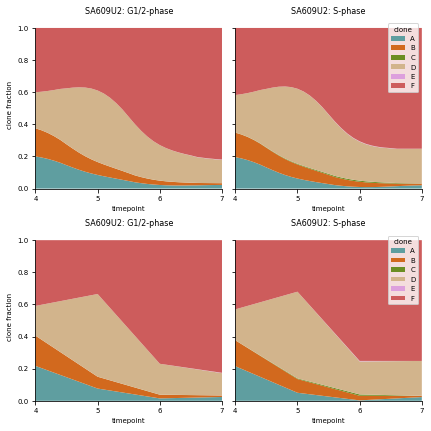

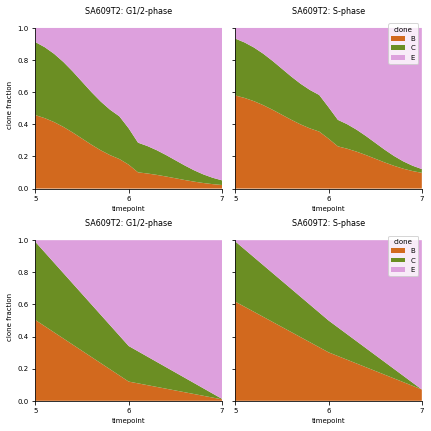

In [8]:
datasets = ['SA1035U', 'SA1035T', 'SA535_CISPLATIN_CombinedU', 'SA535_CISPLATIN_CombinedT', 'SA609U', 'SA609T', 'SA609U2', 'SA609T2']
for d in datasets:
    # load the cell cycle clone counts for SA1035U
    temp_df = pd.read_csv('scdna_replication_paper/analysis/fitness/{}/cell_cycle_clone_counts.tsv'.format(d), sep='\t')

    # sort timepoints based on the timepoint_int column
    temp_df = sort_timepoints(temp_df)

    # find the earliest timepoint in the untreated sample
    earliest_timepoint = sorted(temp_df.timepoint_int.unique())[0]

    # find the set of clone_ids that appear in the union of the treated and untreated samples
    clone_list = list(set(temp_df.clone_id.unique()))
    # fill in missing clones with 0s
    temp_df = fill_in_missing_clones(temp_df, clone_list)

    # sort timepoints again now that we've added the earliest untreated timepoint and filled in missing clones
    temp_df = sort_timepoints(temp_df)

    fig, ax = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True, sharey=True)
    ax = ax.flatten()
    # plot clone fractions for each phase & timepoint in the form of a stackplot
    plot_clone_muller(temp_df, d, ax[0], ax[1], std=5)
    plot_clone_muller(temp_df, d, ax[2], ax[3], interpolate=False)
    sns.despine(ax=ax[0], offset=0, trim=despine_trim)
    sns.despine(ax=ax[1], offset=0, trim=despine_trim)
    sns.despine(ax=ax[2], offset=0, trim=despine_trim)
    sns.despine(ax=ax[3], offset=0, trim=despine_trim)
    plt.show()

### Plot the S-phase enrichment of SA1035U clones across all timepoints

In [22]:
def plot_s_phase_enrichment(df, dataset, ax0, ax1, pt_size=5):
    # compute the maximum and minimum timepoints
    df['timepoint_ind'] = df['timepoint_int'].astype(int)
    max_time = df['timepoint_int'].max()
    min_time = df['timepoint_int'].min()

    pthresh = 1e-2

    # create custom legend for clones & timepoints
    clone_cmap = get_clone_cmap()
    viridis = cm.get_cmap('viridis', 256)
    timepoint_cmap = {}
    clone_legend_elements = [
        Line2D([0], [0], marker='^', color='w', label='enriched'.format(pthresh), markerfacecolor='k', markersize=pt_size),
        Line2D([0], [0], marker='v', color='w', label='depleted'.format(pthresh), markerfacecolor='k', markersize=pt_size)
    ]
    timepoint_legend_elements = clone_legend_elements.copy()
    for i, c in enumerate(sorted(df.clone_id.unique())):
        color = clone_cmap[c]
        # clone_legend_elements.append(Patch(facecolor=color, label=c))

    for i, t in enumerate(sorted(df.timepoint_int.unique())):
        color = viridis((t - min_time) / (max_time - min_time))
        timepoint_str = 'X{}'.format(t)
        timepoint_cmap[timepoint_str] = color
        # timepoint_legend_elements.append(Patch(facecolor=color, label=timepoint_str))

    # draw scatterplot comparing the relative fraction of each clone in S vs G1/2 phases
    for i, row in df.iterrows():
        clone_id = row['clone_id']
        timepoint = row['timepoint']
        if row['positive_p_adj'] < pthresh:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], marker='^', s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=timepoint_cmap[timepoint], marker='^', s=pt_size)
        elif row['negative_p_adj'] < pthresh:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], marker='v', s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=timepoint_cmap[timepoint], marker='v', s=pt_size)
        else:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=timepoint_cmap[timepoint], s=pt_size)

    # draw y=x line where we expect "neutral" clones to lie
    lims = [
        np.min([ax0.get_xlim(), ax0.get_ylim()]),  # min of both axes
        np.max([ax0.get_xlim(), ax0.get_ylim()]),  # max of both axes
    ]
    ax0.plot(lims, lims, 'k--', alpha=0.25, zorder=0)
    ax1.plot(lims, lims, 'k--', alpha=0.25, zorder=0)

    dataset = dataset.replace('_CISPLATIN_Combined', '')

    # ax0.legend(handles=clone_legend_elements, title='clone')
    ax0.legend(handles=clone_legend_elements, title='S-phase', frameon=False, loc='lower right')
    ax0.set_title('{}: S-phase enrichment\ncolored by clone'.format(dataset))
    ax1.set_title('{}: S-phase enrichment\ncolored by timepoint'.format(dataset))
    ax0.set_ylabel('S-phase clone fraction')
    for ax in [ax0, ax1]:
        ax.set_xlabel('G1/2-phase clone fraction')



    

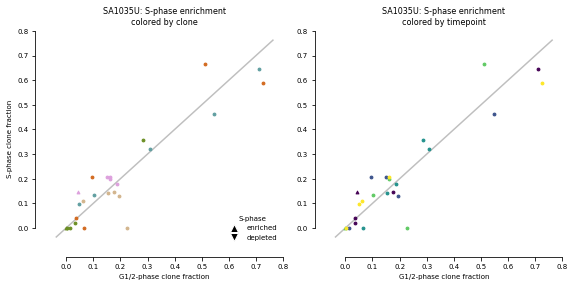

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

# plot S-phase enrichment for SA1035U
plot_s_phase_enrichment(df_SA1035U, 'SA1035U', ax[0], ax[1], pt_size=8)
sns.despine(ax=ax[0], offset=despine_offset, trim=despine_trim)
sns.despine(ax=ax[1], offset=despine_offset, trim=despine_trim)

plt.show()

### Load and process the cell cycle clone counts for all treated or untreated samples in the fitness cohort

In [11]:
def filter_rows(df, num_cells=10):
    """Filters out rows that do not have a value for instantaneous_s or have few cells"""
    df = df.loc[df['instantaneous_s'].notna()]
    df = df.loc[df['num_cells_g'] > num_cells]
    return df


def add_instantaneous_s_and_enrichment(df):
    """Adds a column to the dataframe that contains the observed clone shift in G1/2 population for each clone at each timepoint"""
    # compute the enrichment or depletion for S-phase cells at a given timepoint
    df['clone_frac_diff'] = df['clone_frac_s'] - df['clone_frac_g']

    times = sorted(df.timepoint_int.unique())
    clones = sorted(df.clone_id.unique())

    # this column is a proxy for that clone's instatneous selection coefficient
    df['instantaneous_s'] = np.nan

    # find difference in a clone's number/fraction of cells between two adjacent timepoints
    for t in range(len(times)-1):
        for c in clones:
            t0 = times[t]
            t1 = times[t+1]
            # find the row that corresponds to this clone & time
            row_t0 = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t0)]
            row_t1 = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t1)]
            # find the difference in G1/2-phase fractions between t0 and t1
            frac_diff = row_t1['clone_frac_g'].values[0] - row_t0['clone_frac_g'].values[0]

            # add frac_diff to the dataframe at the appropriate row
            df.loc[(df['clone_id']==c) & (df['timepoint_int']==t0), 'instantaneous_s'] = frac_diff
    return df

In [12]:
fitness_rx_datasets = [
  'SA535_CISPLATIN_CombinedU', 'SA535_CISPLATIN_CombinedT', 'SA1035U', 'SA1035T',
  'SA609U', 'SA609U2', 'SA609T', 'SA609T2'
]

# loop through the samples and compute their S-phase enrichment scores
df_pdx_combined = []
for d in fitness_rx_datasets:
    # read in the data
    temp_df = pd.read_csv('scdna_replication_paper/analysis/fitness/{}/cell_cycle_clone_counts.tsv'.format(d), sep='\t')
    # get the sample name, strip cisplatin suffix from SA535 samples
    sample = d.replace('_CISPLATIN_Combined', '')

    # process the data and plot the s-predictiveness for this sample
    temp_df = sort_timepoints(temp_df)
    temp_df = add_instantaneous_s_and_enrichment(temp_df)
    temp_df = filter_rows(temp_df)

    # save the sample_id in a new column
    temp_df['sample_id'] = sample

    # if 'U' is in the sample name, add a column that indicates that the sample is 'untreated', otherwise it is 'treated'
    if 'U' in sample:
        temp_df['cisplatin'] = 'untreated'
    else:
        temp_df['cisplatin'] = 'treated'
    
    # add the dataframe to the list
    df_pdx_combined.append(temp_df)

# concatenate the dataframes
df_pdx_combined = pd.concat(df_pdx_combined, ignore_index=True)

### Plot the relationship between S-phase enrichment and observed expansion for all clones in the fitness cohort

In [13]:
def get_rx_cmap():
    cmap = {
        'Rx-': '#CCCCCC', # grey
        'U': '#CCCCCC',
        'untreated': '#CCCCCC',
        'Rx+': 'C0',
        'T': 'C0',
        'treated': 'C0'
    }
    return cmap


# create a new plotting function that colors the data points by sample_id and uses different markers for the treatment status
def plot_s_predictiveness_cisplatin_combined(df, ax, pt_size=5, title=None):
    """Plots the observed clone shift in G1/2 population vs. the clone's S-phase enrichment/depletion"""
    cmap = get_rx_cmap()
    # fit a regression line to the data points which are untreated
    sns.regplot(y='instantaneous_s', x='clone_frac_diff', data=df.loc[df['cisplatin']=='untreated'], ax=ax, scatter=True, color=cmap['U'], scatter_kws={'s': pt_size}, label='untreated')
    # fit a regression line to the data points which are treated
    sns.regplot(y='instantaneous_s', x='clone_frac_diff', data=df.loc[df['cisplatin']=='treated'], ax=ax, scatter=True, color=cmap['T'], scatter_kws={'s': pt_size}, label='treated')

    # statistical test to show that the linear regression fit to the treated data is significantly different from the untreated data
    # fit a linear regression to the untreated data
    slope_u, intercept_u, r_value_u, p_value_u, std_err_u = stats.linregress(df.loc[df['cisplatin']=='untreated']['instantaneous_s'], df.loc[df['cisplatin']=='untreated']['clone_frac_diff'])
    # compute the residuals between the treated data and the untreated linear regression model
    residuals = df.loc[df['cisplatin']=='treated']['clone_frac_diff'] - (df.loc[df['cisplatin']=='treated']['instantaneous_s'] * slope_u + intercept_u)
    # fit a linear regression to the residuals
    slope_r, intercept_r, r_value_r, p_value_r, std_err_r = stats.linregress(df.loc[df['cisplatin']=='treated']['instantaneous_s'], residuals)
    # annotate with the p-value of the linear regression fit to the residuals
    ax.annotate('p={:.2e}'.format(p_value_r), xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
    
    # increase the x-axis limits, ticks, and tick labels to be slightly larger than the data
    ax.set_xlim(left=ax.get_xlim()[0] - 0.05, right=ax.get_xlim()[1] + 0.05)
    ax.set_xticks(np.arange(-0.25, 0.3, 0.1))
    ax.set_xticklabels(np.arange(-0.25, 0.3, 0.1).round(2))

    # have the y-axis ticks range from -0.6 to 0.6
    ax.set_ylim(bottom=-0.6, top=0.6)
    ax.set_yticks(np.arange(-0.6, 0.7, 0.2))
    ax.set_yticklabels(np.arange(-0.6, 0.7, 0.2).round(1))

    # set the y-axis label
    ax.set_ylabel('Change in G1/2-phase clone fraction\n<-contraction | expansion->')
    # set the x-axis label
    ax.set_xlabel('SPE score\n<-S-phase depletion | enrichment->')
    # set the title
    if title is not None:
        ax.set_title(title)
    
    # add legend to the top-right corner
    ax.legend(frameon=False, loc='lower right')
    

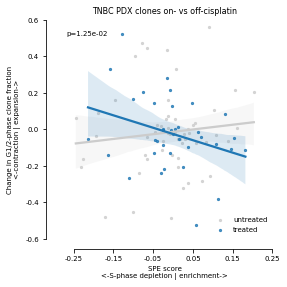

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)

plot_s_predictiveness_cisplatin_combined(df_pdx_combined, ax=ax, title='TNBC PDX clones on- vs off-cisplatin')
sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

plt.show()

### Load and preprocess the SPECTRUM OV-081 data

In [15]:
# load long-form dataframes that have the PERT output for each bin
dataset = 'SPECTRUM-OV-081'
prefix = 'scdna_replication_paper/analysis/spectrum/{}/'.format(dataset)
cn_s_081 = pd.read_csv(prefix+'s_phase_cells_with_scRT_filtered.csv.gz', dtype={'chr':str})
cn_g_081 = pd.read_csv(prefix+'g1_phase_cells_with_scRT_filtered.csv.gz', dtype={'chr':str})


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
# load the cell cycle clone counts for OV-081
df_081 = pd.read_csv('scdna_replication_paper/analysis/spectrum/{}/cell_cycle_clone_counts.csv.gz'.format(dataset))

In [17]:
# delete clone B from the S-phase population and then move all clones up one index (C->B, D->C, etc.) with the exception of clone A
cn_s_081 = cn_s_081.loc[cn_s_081['clone_id'] != 'B']
cn_g_081 = cn_g_081.loc[cn_g_081['clone_id'] != 'B']
df_081 = df_081.loc[df_081['clone_id'] != 'B']
clone_remap_081 = {'C': 'B', 'D': 'C', 'E': 'D', 'F': 'E', 'G': 'F',}
cn_s_081['clone_id'] = cn_s_081['clone_id'].replace(clone_remap_081)
cn_g_081['clone_id'] = cn_g_081['clone_id'].replace(clone_remap_081)
df_081['clone_id'] = df_081['clone_id'].replace(clone_remap_081)

### Plot the PERT CN and replication heatmaps for the SPECTRUM OV-081 data

In [18]:
def get_site_cmap():
    cmap = {
        'SPECTRUM-OV-081_S1_LEFT_ADNEXA': 'powderblue',
        'SPECTRUM-OV-081_S1_INFRACOLIC_OMENTUM': 'darkseagreen',
    }
    return cmap

In [19]:
def plot_pert_cn_rep_heatmaps(
    cn_s, cn_g, ax_cn_s, ax_cn_g, ax_rep_s, ax_rep_g, 
    ax_clone_s, ax_clone_g, ax_time_s, ax_time_g, ax_site_s, ax_site_g,
    clone_col='clone_id', second_sort_col='model_tau', site_col='isabl_sample_id',
    output_cn_col='model_cn_state', output_rep_col='model_rep_state',
    rt_cmap=get_rt_cmap(), clone_cmap=get_clone_cmap(), site_cmap=get_site_cmap(),
    chrom_labels_to_remove=[]
    ):
    ''' 
    Plot PERT output heatmaps for S-phase and G1/2-phase cells. 
    
    Parameters
    ----------
    cn_s : pandas.DataFrame
        long-form dataframe of S-phase cells with pert model results.
        this dataframe should have the following columns in addition to those specified by additional parameters:
            - chr (categorical)
            - start (int)
            - end (int)
            - cell_id (str)
    cn_g : pandas.DataFrame
        long-form dataframe of G1/2-phase cells with pert model results.
        this dataframe should have the following columns in addition to those specified by additional parameters:
            - chr (categorical)
            - start (int)
            - end (int)
            - cell_id (str)
    ax_cn_s : matplotlib.axes.Axes
        axes for the S-phase CN heatmap
    ax_cn_g : matplotlib.axes.Axes
        axes for the G1/2-phase CN heatmap
    ax_rep_s : matplotlib.axes.Axes
        axes for the S-phase replication state heatmap
    ax_rep_g : matplotlib.axes.Axes
        axes for the G1/2-phase replication state heatmap
    ax_clone_s : matplotlib.axes.Axes
        axes for the S-phase clone ID colorbar annotations
    ax_clone_g : matplotlib.axes.Axes
        axes for the G1/2-phase clone ID colorbar annotations
    ax_time_s : matplotlib.axes.Axes
        axes for the S-phase time colorbar annotations
    ax_time_g : matplotlib.axes.Axes
        axes for the G1/2-phase time colorbar annotations
    ax_site_s : matplotlib.axes.Axes
        axes for the S-phase site colorbar annotations
    ax_site_g : matplotlib.axes.Axes
        axes for the G1/2-phase site colorbar annotations
    clone_col : str
        column name for clone IDs
    second_sort_col : str
        column name for secondary sorting of cells (e.g. time in S-phase)
    output_cn_col : str
        column name for output CN states (from pert)
    output_rep_col : str
        column name for output replication states (from pert)
    top_title_prefix : str
        prefix for the title of the top row of plots (corresponding to cn_s)
    bottom_title_prefix : str
        prefix for the title of the bottom row of plots (corresponding to cn_g)
    output_cn_title : str
        title for the output CN heatmap in the middle-right column
    rep_title : str
        title for the replication state heatmap in the far-right column
    rt_cmap : matplotlib.colors.ListedColormap
        colormap for replication states
    clone_cmap : matplotlib.colors.ListedColormap
        colormap for clone IDs
    site_cmap : matplotlib.colors.ListedColormap
        colormap for site IDs
    chrom_labels_to_remove : list
        chromosomes to remove from x-axis to avoid crowding
    '''

    # create mapping of clone IDs
    cluster_col = 'cluster_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(cn_g[clone_col].unique()))])
    cn_g[cluster_col] = cn_g[clone_col]
    cn_g = cn_g.replace({cluster_col: clone_dict})
    cn_s[cluster_col] = cn_s[clone_col]
    cn_s = cn_s.replace({cluster_col: clone_dict})

    # plot the CN states for the S-phase cells
    plot_data_cn_s = plot_clustered_cell_cn_matrix(
        ax_cn_s, cn_s, output_cn_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the replication states for the S-phase cells
    plot_data_rep_s = plot_clustered_cell_cn_matrix(
        ax_rep_s, cn_s, output_rep_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, cmap=rt_cmap, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the CN states for the G1/2-phase cells
    plot_data_cn_g = plot_clustered_cell_cn_matrix(
        ax_cn_g, cn_g, output_cn_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the replication states for the G1/2-phase cells
    plot_data_rep_g = plot_clustered_cell_cn_matrix(
        ax_rep_g, cn_g, output_rep_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, cmap=rt_cmap, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # turn off the y-axis ticks in all subplots
    for ax in [ax_cn_s, ax_cn_g, ax_rep_s, ax_rep_g, ax_clone_s, ax_clone_g, ax_time_s, ax_time_g]:
        ax.set_yticks([])
        ax.set_ylabel('')

    # add the colorbars for clone_id and model_tau
    if len(clone_dict) > 1:
        cell_ids_g = plot_data_cn_g.columns.get_level_values(0).values
        cluster_ids_g = plot_data_cn_g.columns.get_level_values(1).values
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat_g, _ = cncluster.get_cluster_colors(cluster_ids_g, color_map=clone_cmap, return_map=True)

        # get array of second_sort_col values that that match the cell_id order
        condensed_cn_g = cn_g[['cell_id', second_sort_col]].drop_duplicates()
        secondary_array_g = []
        for cell in cell_ids_g:
            g = condensed_cn_g[condensed_cn_g['cell_id'] == cell][second_sort_col].values[0]
            secondary_array_g.append(g)

        # make color mat according to secondary array
        secondary_color_mat_g, _ = make_color_mat_float(secondary_array_g, 'Blues')

        # get array of the site values that match the cell_id order
        condensed_cn_g = cn_g[['cell_id', site_col]].drop_duplicates()
        site_array_g = []
        for cell in cell_ids_g:
            site = condensed_cn_g[condensed_cn_g['cell_id'] == cell][site_col].values[0]
            site_array_g.append(site)
        
        # use mcolors to change every element of the site cmap dict to rgba
        for key in site_cmap.keys():
            site_cmap[key] = mcolors.to_rgba(site_cmap[key])
        site_color_mat_g, _ = cncluster.get_cluster_colors(site_array_g, color_map=site_cmap, return_map=True)

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone_g, color_mat_g)

        # create color bar that shows secondary sort value for each row in heatmap
        plot_colorbar(ax_time_g, secondary_color_mat_g)

        # create color bar that shows site for each row in heatmap
        plot_colorbar(ax_site_g, site_color_mat_g)

        # repeat for the S-phase cells
        cell_ids_s = plot_data_cn_s.columns.get_level_values(0).values
        cluster_ids_s = plot_data_cn_s.columns.get_level_values(1).values
        color_mat_s, _ = cncluster.get_cluster_colors(cluster_ids_s, color_map=clone_cmap, return_map=True)

        # get array of second_sort_col values that that match the cell_id order
        condensed_cn_s = cn_s[['cell_id', second_sort_col]].drop_duplicates()
        secondary_array_s = []
        for cell in cell_ids_s:
            s = condensed_cn_s[condensed_cn_s['cell_id'] == cell][second_sort_col].values[0]
            secondary_array_s.append(s)
        
        # make color mat according to secondary array
        secondary_color_mat_s, _ = make_color_mat_float(secondary_array_s, 'Blues')

        # get array of the site values that match the cell_id order
        condensed_cn_s = cn_s[['cell_id', site_col]].drop_duplicates()
        site_array_s = []
        for cell in cell_ids_s:
            site = condensed_cn_s[condensed_cn_s['cell_id'] == cell][site_col].values[0]
            site_array_s.append(site)

        site_color_mat_s, _ = cncluster.get_cluster_colors(site_array_s, color_map=site_cmap, return_map=True)

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone_s, color_mat_s)

        # create color bar that shows secondary sort value for each row in heatmap
        plot_colorbar(ax_time_s, secondary_color_mat_s)

        # create color bar that shows site for each row in heatmap
        plot_colorbar(ax_site_s, site_color_mat_s)


### Plot the S-phase enrichment of SPECTRUM OV-081 clones across all timepoints

In [20]:
def plot_clone_spf_all_libraries(df, ax, dataset, pt_size=5):
    ''' Plot the distribution of cell cycle phases for each clone across all libraries in a sample '''
    pthresh = 1e-2

    # create custom legend for clones & libraries
    clone_cmap = get_clone_cmap()
    library_cmap = {}
    clone_legend_elements = [
        Line2D([0], [0], marker='^', color='w', label='enriched', markerfacecolor='k', markersize=pt_size),
        Line2D([0], [0], marker='v', color='w', label='depleted', markerfacecolor='k', markersize=pt_size)
    ]
    
    for i, c in enumerate(sorted(df.clone_id.unique())):
        color = clone_cmap[c]
        clone_legend_elements.append(Patch(facecolor=color, label=c))
    
    # the left panel shows the distribution of cell cycle phases for each clone where library_id=='all'
    df2 = df.query('library_id=="all"').reset_index(drop=True)
    for i, row in df2.iterrows():
        clone_id = row['clone_id']
        if row['positive_p_adj'] < pthresh:
            ax.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], c=clone_cmap[clone_id], marker='^', s=pt_size)
        elif row['negative_p_adj'] < pthresh:
            ax.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], c=clone_cmap[clone_id], marker='v', s=pt_size)
        else:
            ax.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], c=clone_cmap[clone_id], s=pt_size)

    # draw y=x line where we expect "neutral" clones to lie
    # limits for the left panel
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', alpha=0.25, zorder=0)

    # ax.legend(handles=clone_legend_elements, title='clone')
    ax.set_xlabel('G1/2-phase clone fraction')
    ax.set_ylabel('S-phase clone fraction')
    ax.set_title('{}: S-phase enrichment'.format(dataset))
    

### Create an entire multipanel figure for the main figure of the paper

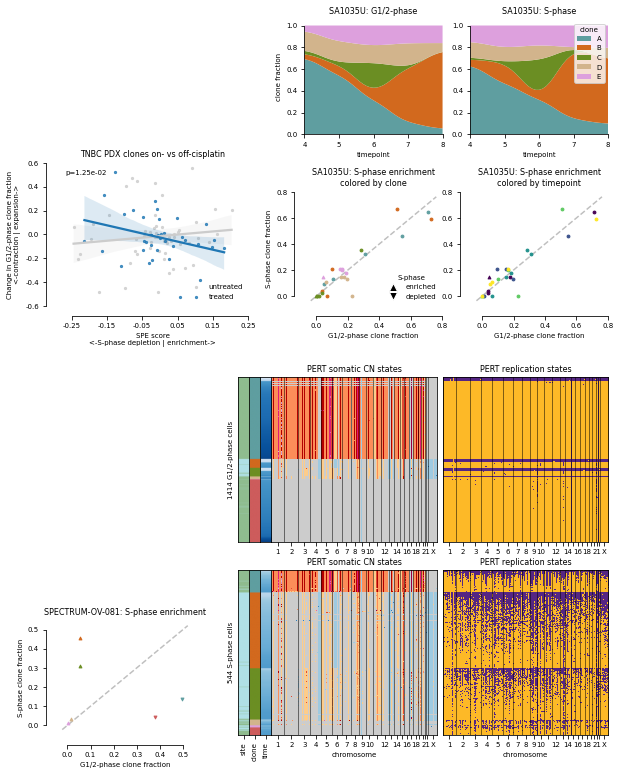

In [21]:
# create a large 8.5 x 11 figure and manually add all the subplots with custom positioning
# since I'm adding labels the figure will be slightly larger than the specified size,
# thus I need to divide the width and height by a multiplicative factor to get the correct size
mult_factor = 1.1081
fig = plt.figure(figsize=(8.5/mult_factor, 11/mult_factor))

# add an axis in the top middle of the figure with size 0.25 x 0.25
ax0 = fig.add_axes([0.45, 0.84, 0.25, 0.16])
ax0.set_title('ax0')

# add an axis in the top right of the figure with size 0.25 x 0.25
ax1 = fig.add_axes([0.75, 0.84, 0.25, 0.16], sharey=ax0)
ax1.set_title('ax1')

# add two more axes underneath the first two axes
ax2 = fig.add_axes([0.45, 0.6, 0.25, 0.16])
ax2.set_title('ax2\nax2')
ax3 = fig.add_axes([0.75, 0.6, 0.25, 0.16], sharey=ax2)
ax3.set_title('ax3')

# add an axes at the same height as ax2 but to the left of ax2
ax4 = fig.add_axes([0.0, 0.6, 0.35, 0.2])
ax4.set_title('ax4')

# add an axes of 0.25 x 0.25 size in the bottom left corner of the figure
ax5 = fig.add_axes([0.0, 0.0, 0.25, 0.16])
ax5.set_title('ax5')

# add four large axes in the bottom right corner of the figure for the CN and replication heatmaps
ax6 = fig.add_axes([0.39, 0.0, 0.3, 0.23])
ax6.set_title('ax6')
ax7 = fig.add_axes([0.39, 0.27, 0.3, 0.23])
ax7.set_title('ax7')
ax8 = fig.add_axes([0.7, 0.0, 0.3, 0.23])
ax8.set_title('ax8')
ax9 = fig.add_axes([0.7, 0.27, 0.3, 0.23])
ax9.set_title('ax9')

# add two barplot annotation columns to the left of ax6 and ax7
# these bars should be the same height as ax6 and ax7 but only 0.02 wide
ax10 = fig.add_axes([0.37, 0.0, 0.02, 0.23])
# ax10.set_title('ax10')
ax11 = fig.add_axes([0.35, 0.0, 0.02, 0.23])
# ax11.set_title('ax11')
ax12 = fig.add_axes([0.33, 0.0, 0.02, 0.23])
# ax12.set_title('ax12')
ax13 = fig.add_axes([0.37, 0.27, 0.02, 0.23])
# ax13.set_title('ax13')
ax14 = fig.add_axes([0.35, 0.27, 0.02, 0.23])
# ax14.set_title('ax14')
ax15 = fig.add_axes([0.33, 0.27, 0.02, 0.23])
# ax15.set_title('ax15')

# turn off the y-axis ticks in all subplots involved in the heatmap
for ax in [eval('ax{}'.format(n)) for n in range(6, 16)]:
    ax.set_yticks([])
    ax.set_ylabel('')

# plot clone fractions for each phase & timepoint in the form of a stackplot
plot_clone_muller(df_SA1035U, 'SA1035U', ax0, ax1)
sns.despine(ax=ax0, offset=0, trim=despine_trim)
sns.despine(ax=ax1, offset=0, trim=despine_trim)

# plot the S-phase enrichment plots in ax2 and ax3
plot_s_phase_enrichment(df_SA1035U, 'SA1035U', ax2, ax3, pt_size=8)
sns.despine(ax=ax2, offset=despine_offset, trim=despine_trim)
sns.despine(ax=ax3, offset=despine_offset, trim=despine_trim)

# plot S-phase enrichment vs observed clone shift in G1/2 population for all PDX samples
plot_s_predictiveness_cisplatin_combined(df_pdx_combined, ax4, title='TNBC PDX clones on- vs off-cisplatin')
sns.despine(ax=ax4, offset=despine_offset, trim=despine_trim)

# plot S-phase enrichment of OV-081 clones across all libraries
plot_clone_spf_all_libraries(df_081, ax5, dataset='SPECTRUM-OV-081', pt_size=8)
sns.despine(ax=ax5, offset=despine_offset, trim=despine_trim)

# plot the PERT output heatmaps for S-phase and G1/2-phase cells
plot_pert_cn_rep_heatmaps(
    cn_s_081, cn_g_081, 
    ax_cn_s=ax6, ax_cn_g=ax7, ax_rep_s=ax8, ax_rep_g=ax9,
    ax_clone_s=ax11, ax_clone_g=ax14, ax_time_s=ax10, ax_time_g=ax13, ax_site_s=ax12, ax_site_g=ax15,
    chrom_labels_to_remove=['11', '13', '15', '17', '19', '20', '22']
)

# set clone and time as the xtick labels for ax11 and ax10, respectively
ax11.set_xticks([0.0])
ax11.set_xticklabels(['clone'], rotation=90)
ax10.set_xticks([0.0])
ax10.set_xticklabels(['time'], rotation=90)
ax12.set_xticks([0.0])
ax12.set_xticklabels(['site'], rotation=90)
ax6.set_xlabel('chromosome')
ax8.set_xlabel('chromosome')
ax12.set_ylabel('{} S-phase cells'.format(cn_s_081.cell_id.nunique()))
ax15.set_ylabel('{} G1/2-phase cells'.format(cn_g_081.cell_id.nunique()))
ax6.set_title('PERT somatic CN states')
ax7.set_title('PERT somatic CN states')
ax8.set_title('PERT replication states')
ax9.set_title('PERT replication states')

fig.savefig('scdna_replication_paper/plots/fitness/main_figure.pdf', dpi=300, bbox_inches='tight')

plt.show()